Classmate Brian Eager formatted the exercises as a Jupyter Notebook template and shared with the class via Teams.

# Week 4 Exercises: Clustering

## 1. Expectation Maximization Clustering

Write a script that implements the Expectation-Maximization (EM) algorithm for clustering (see Algorithm 13.3 in Chapter 13). Run the code on the [iris.txt](http://www.dataminingbook.info/pmwiki.php/Main/ExpectationMaximizationClustering?action=download&upname=iris.txt) dataset. Use the first four attributes for clustering, and use the labels only for the purity-based clustering evaluation (see below). In your implementation, you should estimate the full covariance matrix for each cluster.

For EM initialization, use the first $n/k$ points for cluster 1, the next $n/k$ for cluster 2, and so on. For convergence testing, you can compare the sum of the euclidean distance between the old means and the new means over the $k$ clusters. If this distance is less than $ϵ=0.001$ you can stop the method.

Your program output should consist of the following information:

1. The final mean for each cluster
2. The final covariance matrix for each cluster
3. Number of iterations the EM algorithm took to converge.
4. Final cluster assignment of all the points, where each point will be assigned to the cluster that yields the highest probability $P(C_i|x_j)$
5. Final size of each cluster

Finally, you must compute the 'purity score' for your clustering, computed as follows: Assume that $C_i$ denotes the set of points assigned to cluster $i$ by the EM algorithm, and let $T_i$ denote the true assignments of the points based on the last attribute. Purity score is defined as:

$Purity= \frac{1}{n} \sum_{i=1}^k max_{j=1}^k \{C_i  \cap T_j\}$

In [19]:
# help from A. Fox and S. Sears
#Used this for reference https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
#Also worked with Sam on this. I kept running into a problem with cluster_assignments
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", None, "display.max_columns", None)
#Function to take cluster assignments and truth label objects, create confusion matrix, and return purity
#Reference https://datatofish.com/confusion-matrix-python/
def compute_purity(cluster_assignments, labels):
    confusion_df = pd.DataFrame({'Predicted': cluster_assignments, 'Actual': labels})
    confusion_matrix = pd.crosstab(confusion_df['Predicted'],confusion_df['Actual'],
                                   rownames = ['Predicted'], colnames = ['Actual'])
    #Purity variable, which looks at sum of maxes of cluster assignments and divides by number of points
    purity = np.sum(confusion_matrix.max(axis = 1)) / df.shape[0]
    return purity
#Loading in the iris data
df = pd.read_csv('iris.txt', header = None, names = [1,2,3,4,'Label'])
df_noLabel = df.drop('Label', axis = 1)
labels = df['Label']
#Establishing number of clusters
k = len(labels.unique())
#Threshold given in problem
eps = 0.001
#Fitting the model with sklearn
gmm = GaussianMixture(n_components = k, tol = eps)
gmm.fit(df_noLabel)
#Get predictions
cluster_assignments = gmm.predict(df_noLabel)
df_noLabel['Cluster Assignments'] = cluster_assignments
#Print the results
for cluster in range(k):
    print('Cluster {}'.format(cluster+1))
    print('Size {}'.format(len(df_noLabel[df_noLabel['Cluster Assignments']==cluster])))
    print('Mean {}'.format(gmm.means_[cluster]))
    print('Covariance Matrix:')
    for row in gmm.covariances_[0]:
        print(row)
    print('')
print('Iterations to Converge: {}'.format(gmm.n_iter_))
print('Cluster assignments')
print('Purity: {}'.format(compute_purity(cluster_assignments, labels)))
print(df_noLabel)

Cluster 1
Size 45
Mean [5.9170732  2.77804839 4.20540364 1.29848217]
Covariance Matrix:
[0.2755171  0.09662295 0.18547072 0.05478901]
[0.09662295 0.09255152 0.09103431 0.04299899]
[0.18547072 0.09103431 0.20235849 0.06171383]
[0.05478901 0.04299899 0.06171383 0.03233775]

Cluster 2
Size 50
Mean [5.006 3.418 1.464 0.244]
Covariance Matrix:
[0.2755171  0.09662295 0.18547072 0.05478901]
[0.09662295 0.09255152 0.09103431 0.04299899]
[0.18547072 0.09103431 0.20235849 0.06171383]
[0.05478901 0.04299899 0.06171383 0.03233775]

Cluster 3
Size 55
Mean [6.54639415 2.94946365 5.48364578 1.98726565]
Covariance Matrix:
[0.2755171  0.09662295 0.18547072 0.05478901]
[0.09662295 0.09255152 0.09103431 0.04299899]
[0.18547072 0.09103431 0.20235849 0.06171383]
[0.05478901 0.04299899 0.06171383 0.03233775]

Iterations to Converge: 17
Cluster assignments
Purity: 0.9666666666666667
       1    2    3    4  Cluster Assignments
0    5.9  3.0  4.2  1.5                    0
1    6.9  3.1  4.9  1.5              

## 2. Density Based Clustering: DENCLUE

Write a script to implement the DENCLUE density-based clustering algorithm Algorithm 15.2 in chapter 15. The script should take as input a dataset $D$, the minimum density $ξ$, the tolerance for convergence $ϵ$, and the width $h$. Do not make any assumptions about the data (i.e., column names, etc), except that the last column gives the "true" cluster id.

Run your script on the iris.txt dataset, with $ϵ=0.0001$. Your script should output the following:

1. The number of clusters, and the size of each cluster.
2. The density attractor, followed by the set of point in that cluster.
3. Purity of the clustering, based on the true id.

For Iris, you should use a value of $ξ$ that gives you 3 clusters in the end, i.e., try different values and then finally report only the results for the value that gives you 3 clusters, since there are 3 true clusters in the data. Select the value of $h$ empirically.

To speed up the computation for estimating the density at a point, you may want to first identify the $K$ nearest neighbors, and use only those neighbors.  

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# Prof. Becky put this in Teams.  Got some help with explanations of steps from B. Willis.  A.Fox had to help me finish it off.

import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin
import networkx as nx
import pandas as pd
from scipy.spatial import distance
def _hill_climb(x_t, X, W=None, h=0.36, eps=0.0001):
    """
    This function climbs the 'hill' of the kernel density function and finds the 'peak', which represents the density attractor.
    """
    error = 99.                                             # Guarantee first run, and let it adjust in loop
    prob = 0.
    x_l1 = np.copy(x_t)                                     # X(t+1).  Input record as a copy so we don't alter it
    # Sum of the last three steps is used to establish radius of neighborhood around attractor. Authors suggested two
    # steps works well, but I found three is more robust to noisy datasets.
    radius_new = 0.
    radius_old = 0.
    radius_twiceold = 0.
    iters = 0.
    while True:
        radius_thriceold = radius_twiceold
        radius_twiceold = radius_old
        radius_old = radius_new
        x_l0 = np.copy(x_l1)                                 # X(t)
        x_l1, density = _step(x_l0, X, W=W, h=h)
        error = density - prob
        prob = density
        radius_new = np.linalg.norm(x_l1 - x_l0)
        radius = radius_thriceold + radius_twiceold + radius_old + radius_new
        iters += 1
        if iters > 3 and error < eps:
            break
    return [x_l1, prob, radius]
def _step(x_l0, X, W=None, h=0.36):
    n = X.shape[0]
    d = X.shape[1]
    superweight = 0.                                       # superweight is the kernel X weight for each item
    x_l1 = np.zeros((1, d))
    if W is None:
        W = np.ones((n, 1))
    else:
        W = W
    for j in range(n):
        kernel = kernelize(x_l0, X[j], h, d)
        kernel = kernel * W[j] / (h ** d)
        superweight = superweight + kernel
        x_l1 = x_l1 + (kernel * X[j])
    x_l1 = x_l1 / superweight
    density = superweight / np.sum(W)
    return [x_l1, density]
def kernelize(x, y, h, degree):
    kernel = np.exp(-(np.linalg.norm(x - y) / h) ** 2. / 2.) / ((2. * np.pi) ** (degree / 2))
    return kernel

 
"""Perform DENCLUE clustering from vector array.
    Parameters
    ----------
    h : float, optional
        The smoothing parameter for the gaussian kernel. This is a hyper-
        parameter, and the optimal value depends on data. Default is the
        np.std(X)/5.
    eps : float, optional
        Convergence threshold parameter for density attractors
    min_density : float, optional
        The minimum kernel density required for a cluster attractor to be considered a cluster and not noise.
        Cluster info will stil be kept but the label for the corresponding instances will be -1 for noise.  Since what
        constitutes a high enough kernel density depends on the nature of the data, it's often best to fit the model first and
        explore the results before deciding on the min_density, which can be set later with the 'set_minimum_density' method.
        Default is 0.
    metric : string, or callable
        The metric to use when calculating distance between instances in a feature array. In this version, 
        I've only tested 'euclidean' at this moment.

    Attributes
    -------
    cluster_info_ : dictionary [n_clusters]
        Contains relevant information of all clusters (i.e. density attractors).  Information is retained even
        if the attractor is lower than the minimum density required to be labeled a cluster.
    labels_ : array [n_samples]
        Cluster labels for each point.  Noisy samples are given the label -1    
"""
class DENCLUE(BaseEstimator, ClusterMixin):
          
    def __init__(self, h=0.36, eps=0.0001, min_density=0.13, metric='euclidean'):
        self.h = h
        self.eps = eps
        self.min_density = min_density
        self.metric = metric
    def classify(self, X, y=None, sample_weight=None):
        if not self.eps > 0.0:
            raise ValueError("eps must be positive.")
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1]
        density_attractors = np.zeros((self.n_samples, self.n_features))
        radii = np.zeros((self.n_samples, 1))
        density = np.zeros((self.n_samples, 1))
        if self.h is None:
            self.h = np.std(X) / 5
        if sample_weight is None:
            sample_weight = np.ones((self.n_samples, 1))
        else:
            sample_weight = sample_weight
        labels = -np.ones(X.shape[0])                     # Proposed labels that we will have to try to gauge the purity of
        for i in range(self.n_samples):                   # Calculate a density attractor for each row
            density_attractors[i], density[i], radii[i] = _hill_climb(X[i], X, W=sample_weight,
                                                                      h=self.h, eps=self.eps)
            
        # Initialize cluster graph to finalize clusters. Networkx graph is used to verify clusters, which are connected
        # components of the graph. Edges are defined as density attractors being in the same
        # neighborhood as defined by our radii for each attractor.
        cluster_info = {}
        num_clusters = 0
        cluster_info[num_clusters] = {'instances': [0],
                                      'centroid': np.atleast_2d(density_attractors[0])}
        g_clusters = nx.Graph()                           # Create graph for clustering
        for j1 in range(self.n_samples):                  # Populate the graph with all the nodes
            g_clusters.add_node(j1, attr_dict={'attractor':density_attractors[j1], 'radius':radii[j1],
                                'density':density[j1]})
        for j1 in range(self.n_samples):
            for j2 in (x for x in range(self.n_samples) if x != j1):
                if g_clusters.has_edge(j1, j2):
                    continue
                # Get difference in between these attractors
                diff = np.linalg.norm(g_clusters.node[j1]['attractor'] - g_clusters.node[j2]['attractor'])
                # If the distance is less than the sum of the two radii, then add file edge to this cluster
                if diff <= (g_clusters.node[j1]['radius'] + g_clusters.node[j1]['radius']):
                    g_clusters.add_edge(j1, j2)
        # Get clusters and initialize the cluster count
        clusters = list(nx.connected_component_subgraphs(g_clusters))
        num_clusters = 0
        # For each cluster (subgraph) in the overall cluster
        for clust in clusters:
            # Get instance of the max density and get the density and centroid in each cluster
            max_instance = max(clust, key=lambda x: clust.node[x]['density'])
            max_density = clust.node[max_instance]['density']
            max_centroid = clust.node[max_instance]['attractor']
            complete = False
            c_size = len(clust.nodes())
            if clust.number_of_edges() == (c_size * (c_size - 1)) / 2.:
                complete = True
            cluster_info[num_clusters] = {'instances': clust.nodes(),
                                          'size': c_size,
                                          'centroid': max_centroid,
                                          'density': max_density,
                                          'complete': complete}
            # if cluster density is not higher than the minimum, instances are kept classified as noise
            if max_density >= self.min_density:
                labels[clust.nodes()] = num_clusters
            num_clusters += 1
        self.clust_info_ = cluster_info
        self.labels_ = labels
        return self
iris = pd.read_csv('iris.txt', header = None)
data = iris[[0,1,2,3,4]].values
samples = np.mat(data[:,0:4])
true_labels=data[:,-1]
labels = list(set(true_labels))
true_id = np.zeros((3, 50))
index = range(len(true_labels))
for i in range(len(labels)):
    true_id[i]=[j for j in index if true_labels[j]==labels[i]]
d = DENCLUE(0.36, .0001, .13)
d.classify(samples)
results = d.clust_info_
for key, value in results.items():
    print('Final Size of Cluster: {}'.format(results[key]['size']))
    print('Density Attractor: {}\n'.format(results[key]['centroid']))

# Function to return purity of clusters, with help from A. Fox and S. Sears
# https://datatofish.com/confusion-matrix-python/
def purity_true_id(true_id, instances):
    # Get n from instances argument
    n = 0
    for points in instances:
        n += len(points)
    temp_sum = 0                    # Running sum for calculation
    # Iterate through instances to find the max intersection between true id and instances
    for cluster in range(len(instances)):
        max_cluster = 0
        for i in range(len(true_id)):
            max_check = len(list(set(instances[cluster]).intersection(true_id[i])))
            if max_check > max_cluster:
                max_cluster = max_check
        temp_sum += max_cluster
    # Divide sum of max intersections by n
    purity = temp_sum / n
    return purity
# Loading in data and setting variables needed
iris = pd.read_csv('iris.txt', header = None)
data = iris[[0,1,2,3,4]].values
samples = np.mat(data[:,0:4])
true_labels=data[:,-1]
labels = list(set(true_labels))
true_id = np.zeros((3, 50))
index = range(len(true_labels))
for i in range(len(labels)):
    true_id[i]=[j for j in index if true_labels[j]==labels[i]]
d = DENCLUE(0.36, .0001, .13)
d.classify(samples)
results = d.clust_info_
# Add cluster classifications to pandas df
iris = iris.rename(columns = {0:1, 1:2, 2:3, 3:4, 4:'Labels'})
iris['Cluster'] = ""
for cluster in range(len(results)):
    for point in results[cluster]['instances']:
                  iris['Cluster'][point] = cluster
# Create instances array to compare to True ID
instances = []
for cluster in range(len(results)):
    instances.append(results[cluster]['instances'])
# Print final results
print('Final Number of Clusters: {}'.format(len(results)))
print('Purity: {} \n'.format(purity_true_id(true_id, instances)))
for cluster in range(len(results)):
    print('Cluster: {}'.format(cluster))
    print('Size of Cluster: {}'.format(results[cluster]['size']))
    print('Density Attractor: {}'.format(results[cluster]['centroid']))
    print('Points in Each Cluster: \n {} \n'.format(iris[iris['Cluster']==cluster]))    

Final Size of Cluster: 68
Density Attractor: [6.18843436 2.89824105 4.71897548 1.56280594]

Final Size of Cluster: 50
Density Attractor: [4.9747532  3.35428642 1.47776422 0.23667237]

Final Size of Cluster: 32
Density Attractor: [6.43604049 2.96603323 5.28859997 1.95415606]

Final Number of Clusters: 3
Purity: 0.88 

Cluster: 0
Size of Cluster: 68
Density Attractor: [6.18843436 2.89824105 4.71897548 1.56280594]
Points in Each Cluster: 
        1    2    3    4           Labels Cluster
0    5.9  3.0  4.2  1.5  Iris-versicolor       0
1    6.9  3.1  4.9  1.5  Iris-versicolor       0
2    6.6  2.9  4.6  1.3  Iris-versicolor       0
4    6.0  2.2  4.0  1.0  Iris-versicolor       0
7    5.8  2.7  5.1  1.9   Iris-virginica       0
12   5.7  3.0  4.2  1.2  Iris-versicolor       0
13   6.1  3.0  4.9  1.8   Iris-virginica       0
17   5.7  2.8  4.1  1.3  Iris-versicolor       0
20   5.9  3.0  5.1  1.8   Iris-virginica       0
21   6.5  3.0  5.2  2.0   Iris-virginica       0
23   5.5  2.5  4.0  

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\ipykernel_launcher.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3. Clustering

The data for this portion of the assignment will be the Iris flower dataset. The dataset consists of 50 samples from each of three species of Iris, with four features measured from each sample.scikit-learn provides a function to load the dataset (no download required).

### The Idea: Choosing $k$ for $k$-means

Your objective here will be to assess the performance of k-means clustering on the Iris dataset. Recall that the number of clusters, $k$, is an input parameter to the $k$-means algorithm. A variety of measurements are available for estimating the optimal value of $k$. For this assignment, you will look at the sum of squared deviation (SSQ) and the gap statistic. Both of these criteria make use of the intuition that $k$-means tries to minimize variance (the distance or deviation of each point from each of the $k$ clusters) by iteratively assigning points to their nearest clusters.

### Choosing $k$ with SSQ

The SSQ criterion is a direct application of the intuition that $k$-means tries to minimize variance. Recall that the SSQ criterion sweeps over a range of possible $k$ values, with each value of $k$ associated with a degree of deviation (the distance of each point from each of the $k$ clusters). These deviations can be squared and summed to arrive at the “sum of squared deviation” (SSQ) for each value of $k$. Larger values of $k$ are expected to continue to reduce the SSQ (because there are more clusters for points to be near, reducing their deviation). However, one could expect a leveling-off in the SSQ once the value of $k$ exceeds the true number of clusters, as this would result in true clusters (that is, clusters actually present in the data) being separated. If, then, one plots the SSQ over a range of $k$ values, this leveling-off point may produce a noticeable “elbow” in the plot. By this criterion, the estimated optimal value of $k$ is that which occurs at this elbow point. While simple, the difficulty with this criterion is that often the elbow point is not distinctive or well-defined.

### What to Provide

Your output should contain the following:

1. The SSQs computed fork values between 1 and 10 (inclusive). There should be one plot corresponding to the SSQs.
2. The gap statistics computed fork values between 1 and 10 (inclusive). There should be two plots corresponding to the gap statistics.

Given this output, respond to the following questions:

1. Where did you estimate the elbow point to be (between what values of $k$)? What value of $k$ was typically estimated as optimal by the gap statistic? To adequately answer this question, consider generating both measures several times, as there may be some amount of variation in the value of $k$ that they each estimate as optimal.
2. How close are the estimates generated by the elbow point and gap statistic to the number of species of Iris represented in the dataset?
3. Assuming we are trying to generate one cluster for each Iris species represented in the dataset, does one measure seem to be a consistently better criterion for choosing the value of $k$ than the other? Why or why not?

1 - SSQ

Clusters and with SSE Values
----------------------------------------
Clusters: 1 	SSE: 681.3706
Clusters: 2 	SSE: 152.3479517603579
Clusters: 3 	SSE: 81.70628013582343
Clusters: 4 	SSE: 59.34876557610241
Clusters: 5 	SSE: 46.98506112266112
Clusters: 6 	SSE: 39.57886631746632
Clusters: 7 	SSE: 35.25750383733913
Clusters: 8 	SSE: 31.539437170672464
Clusters: 9 	SSE: 29.412607333842633
Clusters: 10 	SSE: 27.330464476699774


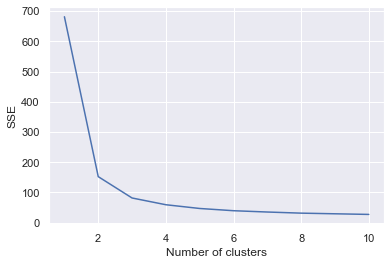

In [21]:
# Referenced from https://stackoverflow.com/questions/19197715/sckit-learn-k-means-elbow-criterion for most of the coding
# and https://github.com/hevronig/ca4ls/blob/105e2f234ea46f3e64c0a823c998eb9fecc3da4b/gap.py
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def sse_form(data, n):                            # Function to perform Kmeans using data and number of clusters
    sse = {}
    for k in range(1, n+1):
        kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(data)
        data["clusters"] = kmeans.labels_
        sse[k] = kmeans.inertia_                  # Inertia: Sum of distances of samples to their closest cluster center
    return(sse)

def sse_pretty(sse_values):                       # Function to print results of clusters and SSE values
    print('Clusters and with SSE Values')
    print('-'*40)
    for k,v in sse_values.items():
        print('Clusters: {} \tSSE: {}'.format(k,v))
        
def elbow_plt(sse):                               # Function to create the plot for elbow
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()
   

def main():                                       # load the data, call all the functions, perform exception handling
    try:
        # loading iris dataset from sklearn datasets
        iris = load_iris()
        df = pd.DataFrame(iris.data, columns=iris['feature_names'])
        k = 10
        # Pulling in other functions
        sse_values = sse_form(df, k)              # Calling first function
        sse_pretty(sse_values)                    # Calling second function
        elbow_plt(sse_values)                     # Calling third function
    except Exception as exception:
        print('exception')
        traceback.print_exc()
        print('An exception of type{0} occurred.'.format(type(exception).__name__, exception.args));
main()

2 - Gap Statistics

In [22]:
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
df = pd.DataFrame(iris.data)
data = df[[0,1,2,3]].values

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\scipy\cluster\vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


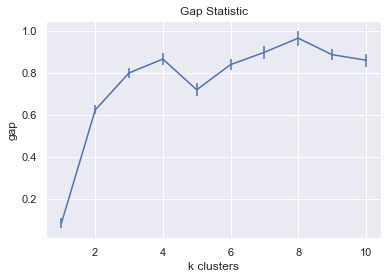

In [23]:
# got help from A. Fox and Torrey C. and https://github.com/hevronig/ca4ls/blob/105e2f234ea46f3e64c0a823c998eb9fecc3da4b/gap.py
# def gap() came from Github example of Mikael Vejdemo-Johansson (2013), using the Tibshirani paper as reference
import numpy as np
import pandas as pd
# found out some of scipy (log, mean, diags, sqrt) was being deprecated so had to switch to numpy for those parts
import scipy                           # Yes, I know StackOverflow says I should never need to do this.
import scipy.cluster.vq
from numpy.lib import scimath
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import traceback


dst = scipy.spatial.distance.euclidean

def gap(data, refs=None, nrefs=20, ks=range(1,11)):
    """Compute the Gap statistic for an nxm dataset in data.  Either give a precomputed set of reference distributions in 
    refs as an (n,m,k) scipy array, or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.  Give the list of k-values for which you want to compute the 
    statistic in ks."""
    
    shape = data.shape
    if refs == None:
        tops = data.max(axis=0)
        bots = data.min(axis=0)
        dists = scipy.matrix(np.diag(tops-bots))
        rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs
        
    gaps = np.zeros((len(ks),))
    errors = np.zeros((len(ks),))
    labels = dict((el,[]) for el in ks)
    for (i,k) in enumerate(ks):
        (kmc,kml) = scipy.cluster.vq.kmeans2(data,k)
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])
        labels[k] = kml
        
        refdisps = np.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        gaps[i] = scimath.log(np.mean(refdisps))-scimath.log(disp)                                        # Compute gaps
        errors[i] = scimath.sqrt(sum(((scimath.log(refdisp)-np.mean(scimath.log(refdisps)))**2) \
                                     for refdisp in refdisps)/float(nrefs)) * scimath.sqrt(1+1/nrefs)     # Compute errors
        
    return gaps, labels, errors                         # You can't just print them.  Have to put them into a chart.
   
'''Function to plot the gap statistic'''
def gap_stat_plt(gaps, errors):
    xval = range(1,len(gaps)+1)
    yval = gaps
    plt.errorbar(xval,yval,xerr=None, yerr=errors)
    plt.xlabel('k clusters')
    plt.ylabel('gap')
    plt.title('Gap Statistic')
    plt.show()

gaps, labels, errors = gap(data, refs=None, nrefs=20, ks=range(1,11))

gap_stat_plt(gaps, errors)

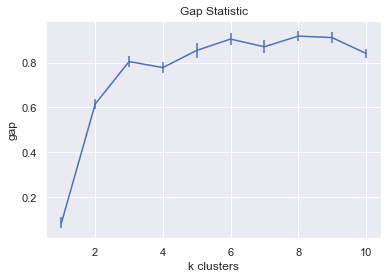

In [24]:
gaps, labels, errors = gap(data, refs=None, nrefs=20, ks=range(1,11))

gap_stat_plt(gaps, errors)

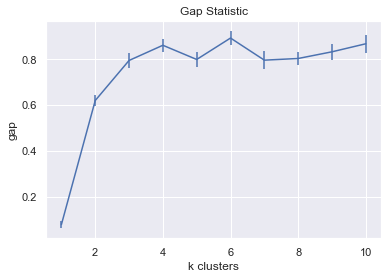

In [25]:
gaps, labels, errors = gap(data, refs=None, nrefs=20, ks=range(1,11))
gap_stat_plt(gaps,errors)

***Written Responses by Student Here***

1. The elbow point is at 2 or 3.  The gap statistic shows 3 as being optimal.
2. They are both close (to 3), but the gap statistic is closer.  Or I might be mis-reading the elbow chart!
3. The gap statistics method seems to work better, probably because the SSQ keeps adding 1 each time, making it a moving target.

## 4. Complete the following in your text:

### Exercise 7.2.2 'Gold Nugget' book p. 255:  How would the clustering of Example 7.2 change if we used for the distance between two clusters:
(a) The minimum of the distances between any two points, once from each cluster.
(b) The average of the distances between pairs of points, one from each of the two clusters.

[0 0 0 0 1 1 1 1 1 2 2 2]
1.4142135623730951
(a) "In general, it is possible that this rule will result in an entirely different clustering from that obtained 
using the distance-of-centroids rule."


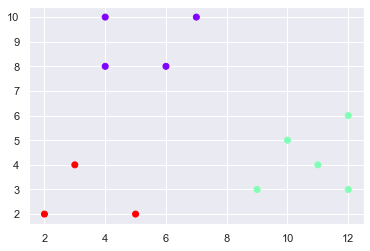

In [26]:
# with help from classmate A. Fox and https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn/
'''Use the AgglomerativeClustering class from the sklearn.cluster library. The number of clusters is set to 3 using the 
n_clusters parameter.  affinity is set to "euclidean" (distance between the datapoints). The linkage parameter is set to "ward," 
which minimizes the variant between the clusters.  Then call the fit_predict method from the AgglomerateClustering class 
variable cluster.'''

import matplotlib.pyplot as plt                             # import the required libraries
import pandas as pd
%matplotlib inline
import numpy as np
from sklearn.cluster import AgglomerativeClustering         # import the class for clustering. Will call its fit_predict method 

points = np.array([[4,10],[7,10],[4,8],[6,8],[10,5],[12,6],[11,4],[12,3],[9,3],[3,4],[5,2],[2,2],])        # create the dataset

cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(points)             # fit_predict() method returns the names of the clusters that each data point belongs to

print(cluster.labels_)     # output is a 1-D array of 12 elements corresponding to the clusters assigned to our 12 data points
# the 0s, 1s, and 2s are "merely labels assigned to the clusters and have no mathematical implications"

# plot the clusters
plt.scatter(points[:,0],points[:,1], c=cluster.labels_, cmap='rainbow')

def euclideanDistance(coordinate1, coordinate2):
    return pow(pow(coordinate1[0] - coordinate2[0], 2) + pow(coordinate1[1] - coordinate2[1], 2), .5)

distances = []
for i in range(len(points) - 1):
    for j in range(i+1, len(points)):
        distances += [euclideanDistance(points[i],points[j])]
print(min(distances))
print('(a) "In general, it is possible that this rule will result in an entirely different clustering from that obtained \nusing the distance-of-centroids rule."')
# That was a quote from the text.

In [27]:
mean_distance = points.mean()
print('(b) The average of the distances between pairs of points, one from each of the clusters, is:')
print(mean_distance)

(b) The average of the distances between pairs of points, one from each of the clusters, is:
6.25


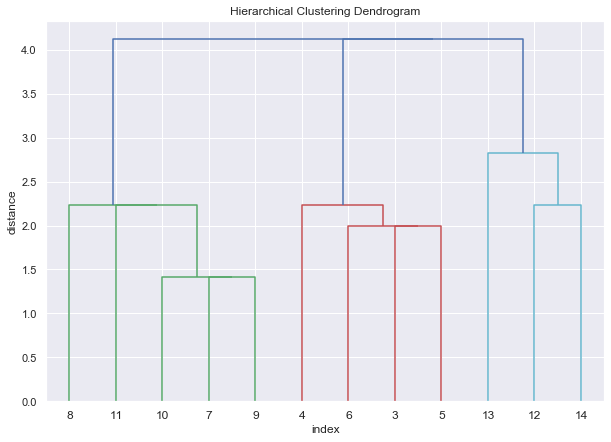

In [28]:
# put the code to create the dendrogram here, in case I want to refer back to it in future.  From A. Fox

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Created array to hold the 12 points from p. 248
points = np.array([[4,10],[7,10],[4,8],[6,8],[10,5],[12,6],[11,4],[12,3],[9,3],[3,4],[5,2],[2,2],])

# Calculates closest points to each other
linked = linkage(points, 'single')

# Defines the range of the x axis.  Need to go to 15 to make sure 14 gets included
labelList = range(1, 15)

# Plotting the hierarchical clustering dendrogram
plt.figure(figsize=(10,7))
dendrogram(linked, orientation = 'top', labels = labelList, distance_sort = 'descending', show_leaf_counts = True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
plt.show()

# This works.

### Exercise 7.3.4 'Gold Nugget' book p. 263: For the three clusters of Fig. 7.8; (a) Compute the representation of the cluster as in the BFR Algorithm.  That is, compute N, SUM, and SUMSQ.  (b) Compute the variance and standard deviation of each cluster in each of the two dimensions.

In [29]:
# help from A.Fox and S.Sears and
# https://github.com/mansiganatra/Bradley-Fayyad-Reina-BFR-algorithm-implementation/blob/master/Mansi_Ganatra_bfr.py

import numpy as np
# Creating arrays for the clusters.  Cluster is based off visual from 'gold nugget' text
c1 = np.array([[4,10],[7,10],[4,8],[6,8]])
c2 = np.array([[3,4],[2,2],[5,2]])
c3 = np.array([[10,5],[12,6],[11,4],[9,3],[12,3]])

clusters = [c1, c2, c3]                                   # Combining clusters in one list

for cluster in clusters:
    N = len(cluster)                                      # N is the number of points in a cluster
    SUM = tuple(np.sum(cluster, axis = 0))                # SUM looks at the sum of x's and y's
    SUMSQ = tuple(np.sum(np.square(cluster), axis = 0))   # SUMSQ sum of the squares.
    variance = tuple(np.divide(SUMSQ, N) - np.square((np.divide(SUM, N)))) # Variance is avg of the squared differences
    std = tuple(np.sqrt(variance))                        # standard variance is square root of variance
    print('Cluster: {}'.format(cluster))
    print('\n N: {}'.format(N))
    print('SUM: {}'.format(SUM))
    print('SUMSQ: {}'.format(SUMSQ))
    print('Variance: {}'.format(variance))
    print('Standard Deviation: {}\n'.format(std))

Cluster: [[ 4 10]
 [ 7 10]
 [ 4  8]
 [ 6  8]]

 N: 4
SUM: (21, 36)
SUMSQ: (117, 328)
Variance: (1.6875, 1.0)
Standard Deviation: (1.299038105676658, 1.0)

Cluster: [[3 4]
 [2 2]
 [5 2]]

 N: 3
SUM: (10, 8)
SUMSQ: (38, 24)
Variance: (1.5555555555555536, 0.8888888888888893)
Standard Deviation: (1.2472191289246464, 0.9428090415820636)

Cluster: [[10  5]
 [12  6]
 [11  4]
 [ 9  3]
 [12  3]]

 N: 5
SUM: (54, 21)
SUMSQ: (590, 95)
Variance: (1.3599999999999852, 1.3599999999999994)
Standard Deviation: (1.1661903789690538, 1.1661903789690597)



### Exercise 7.3.5 'Gold Nugget' book p. 264: Suppose a cluster of three-dimensional points has standard deviation of 2, 3, and 5, in the three dimensions, in that order.  Compute the Mahalanobis distance between the origin (0,0,0) and the point (1, -3, 4).

In [30]:
# help from A. Fox and S. Sears

from scipy.spatial import distance
def mahalanobis_distance(std, point1, point2):  # origin goes in as point1 and point goes in as point2
    '''Computes Mahalanobis Distances given standard deviation and two point lists all of equal length/dimensions.'''
    dimensions = len(std)
    temp = 0
    for i in range(dimensions):
        temp += ((point1[i] - point2[i])/std[i])**2
    distance = temp**(1/2)
    return distance

point = [1, -3, 4]
origin = [0,0,0]
std = [2,3,5]
mahalanobis_distance(std, origin, point)

1.374772708486752